# Analysis of Sonogashira reaction mixture

Here, we will analyze elemental compositions of the ions, present in the Sonogashira reaction mixture

## Import required packages

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

from mass_automation.experiment import Experiment

from mass_automation.deisotoping.process import MlDeisotoper
from mass_automation.formula import RealIsotopicDistribution
from mass_automation.formula.model import LSTM
from mass_automation.formula.data import pack_sequence

from mass_automation.plot import plot_spectrum

## Open the experimental data

In [2]:
exp = Experiment('../reaction_mixture.mzXML', 128, 16)

## Perform deisotoping

As a guideline, if you are interested in studying less intensive signals, select CatBoost model, if you want to analyzed only major signals, then choose XGBoost model

In [3]:
deisotoper = MlDeisotoper().load('data/models/xgb_model.pkl')
deisotoped_spectrum = deisotoper(exp[0])

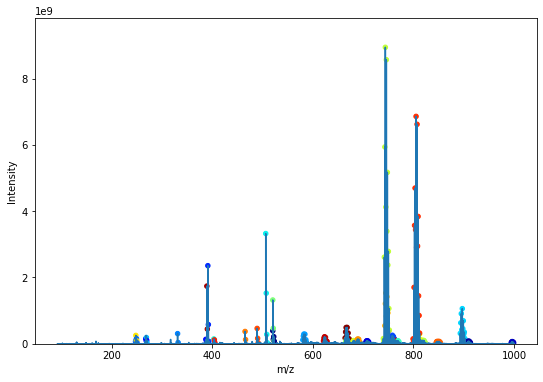

In [4]:
plot_spectrum(exp[0], labels=deisotoped_spectrum)

Let's look closer to two the most abundant Pd-complexes

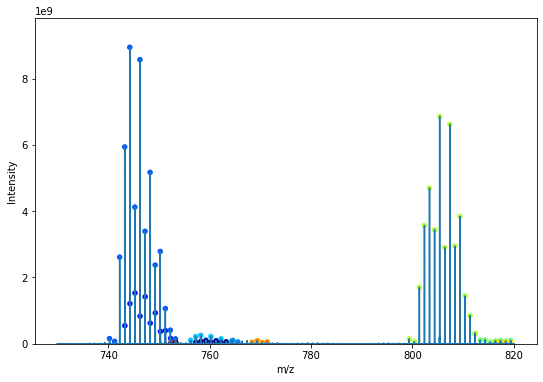

In [5]:
plot_spectrum(exp[0], labels=deisotoped_spectrum, x_left=730, x_right=820)

## Load the model

Here we will use the classification model to study elements present in the ions.

In [6]:
model = LSTM.load_from_checkpoint('nn_models/classification/lstm_bi_clf_full.ckpt')
model.eval()

LSTM(
  (lstm): LSTM(100, 256, num_layers=3, dropout=0.5, bidirectional=True)
  (decoder): LinearWithHidden(
    (embedder): Sequential(
      (0): Linear(in_features=1536, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=119, bias=True)
      (4): Sigmoid()
    )
  )
  (loss): BCELoss()
)

In [7]:
distribution2elements = {}

for i in trange(int(deisotoped_spectrum.max()+1)):
    ri = RealIsotopicDistribution(exp[0], np.where(deisotoped_spectrum == i)[0])

    representations, represeantaion_masses = zip(*ri.get_representation(f=np.mean, mode='middle', length=101))
    representations_centered = []
    
    
    for representation, representaion_mass in zip(representations, represeantaion_masses):
        center = np.argmax(representation[40:60])-50+40

        centered_representation = representation
        med = np.median(centered_representation)
        
        centered_representation[:20] = med
        centered_representation[-20:] = med

        if center < 0:
            centered_representation = np.array([med]*(-center)+list(representation[:center]))
        else:
            centered_representation = np.array(list(representation[center:])+[med]*center)
        
        representations_centered.append(centered_representation-med)
        representations_centered[-1][-1] = representaion_mass/1000

    sum_ = max([item.max() for item in representations_centered])
    representations_centered = [item/sum_ for item in representations_centered]
    
    # Optionally, you can filter isotopic variants with lower intensity by uncommenting the following line
    # representations_centered = [item for item in representations_centered if item.max() > .05]
    
    out = model.forward(pack_sequence([torch.FloatTensor(representations_centered)]*2)).detach().cpu().numpy()[0]
    out = dict(zip(range(1, 120), out))
    
    distribution2elements[i] = out

In [8]:
ATOMIC_NUMBER = 46

element_probs = np.array([distribution2elements[pred][ATOMIC_NUMBER] if pred != -1 else None for pred in deisotoped_spectrum])

In [9]:
x_left=475
x_right=1000

masses = exp[0].masses
ints = exp[0].ints

slice_masses = masses[(masses >= x_left) & (masses <= x_right)]
slice_ints = ints[(masses >= x_left) & (masses <= x_right)]

def apply(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])

    plt.xlim(x_left, x_right)
    plt.ylim(0, 1.1*slice_ints.max())

As the classification models are poorly callibrated and the experimental data might be different from the training, threshold should be selected on case-by-case basis.

If you need good performance out-of-the-box, you may wish to try the `nn_models/classification/lstm_mono_full_wo_sampling.ckpt` model, which emperically has much better calibration

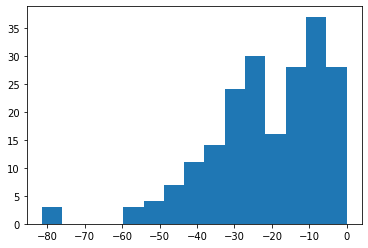

In [10]:
plt.hist(np.log(element_probs[element_probs!=None].astype(float)), bins=15)
plt.show()

Let's which ions in the spectrum contain palladium

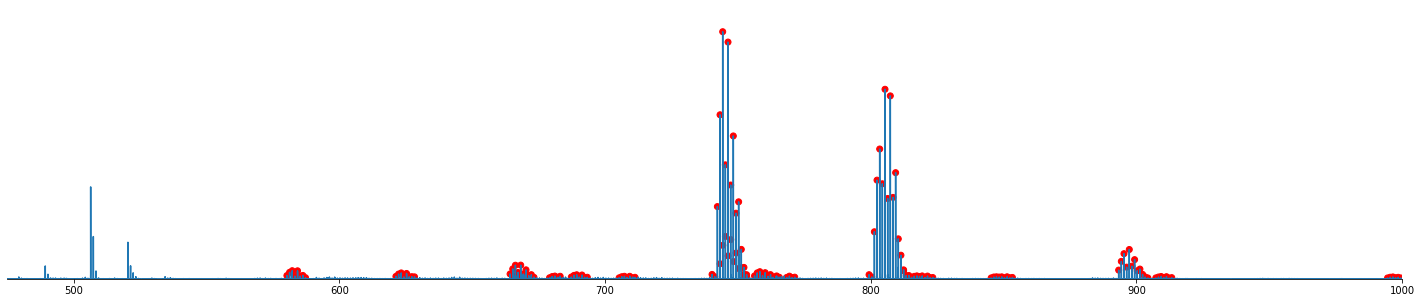

In [11]:
plt.figure(figsize=(25,5))

THRESHOLD = 1e-20

ax = plt.subplot(111)
plt.plot(slice_masses, slice_ints)
plt.scatter(
    masses[element_probs!=None],
    ints[element_probs!=None],
    c=element_probs[element_probs!=None] > THRESHOLD, alpha=element_probs[element_probs!=None] > THRESHOLD, cmap='rainbow')
apply(ax)